# Question 4: The West Coast Heatwave, Figure 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [3]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

## Calculating SST Data from 2002-2012 for Anomaly Calculations

Figure 1 shows the monthly anomalies for 2014-2016, using SST from 2002-2012 per month and per location as the baseline. So, we first need to calculate this baseline, as well as gathering our relevant years.

In [4]:
trend_data = ds.analysed_sst.sel(time=slice('2002', '2012'))

baseline = trend_data.groupby('time.month').mean(skipna=True)

## Creating Figures

We now plot the anomalies for 2014, 2015, and 2016 (only through September for 2016) based on location. We calculate the anomaly per month by subtracting the baseline month mean from the observed month mean, and then plot these on the maps based on the longitude and latitude. 

In [5]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [6]:
def get_anomaly(year, mon):
    ''' Calculates the anomaly for the month (1 to 12) in the given year '''
    month_data = ds.analysed_sst.sel(time=f'{month_names[mon-1]}, {year}')
    month_mean = month_data.mean(dim='time')
    return month_mean - baseline.sel(month=mon)

In [7]:
def annotate_map(ax, month=None, xticks=False, yticks=False):
    '''
    Helper function for adding latitude/longitude ticks,
    land lines, and subplot letter label to map.
    '''
    # add lat/lon axis ticks
    if yticks:
        ax.set_yticks([35, 40, 45], crs=crs)
        ax.set_ylabel(None)
    if xticks:
        ax.set_xticks([-130, -120], crs=crs)
        ax.set_xlabel(None)

    # add land & coastlines
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))

    # add subplot month label in the top right
    if month:
        ax.text(-118.5, 48, month, c='white', size='x-large',
                weight=500, ha='right', va='top')

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

jet = cm.get_cmap('jet', 256)
newcolors = jet(np.linspace(0, 1, 256))
newcolors[100:150, :] = np.array([1, 1, 1, 1]) # white
custom_cmap = ListedColormap(newcolors)

In [9]:
def make_fig(ax, month, anomaly, xticks=False, yticks=False):
    ''' Plots given anomaly '''
    anomaly.plot(ax=ax, transform=crs, cmap=custom_cmap,
                        add_colorbar=False,
                        vmin=-3, vmax=3
    )

    annotate_map(ax, month, xticks=xticks, yticks=yticks)

In [10]:
def plot_nodata(ax):
    # match style of other plots
    ax.set_xlim(ds.lon.min(), ds.lon.max())
    ax.set_ylim(ds.lat.min(), ds.lat.max())
    ax.grid(False)
    
    annotate_map(ax, xticks=True)
    
    ax.text(-130, 35, "No data", size="large", color="black", fontweight="semibold", zorder=5, rotation=90)
    
    points = np.array([
        [-124.5639997, 42.8376089],
        [-124.4095, 40.440132],
        [-121.898460, 36.603954],
        [-119.698189, 34.420830],
        [-124.053452, 44.636784]
    ])
    
    ax.scatter(points[:,0], points[:,1], marker='o', c='r', s=8, zorder=6)

In [11]:
anomalies = {}
for year in np.arange(2014, 2017):
    for month in np.arange(1, 13):
        anomalies[(month, year)] = get_anomaly(year, month)

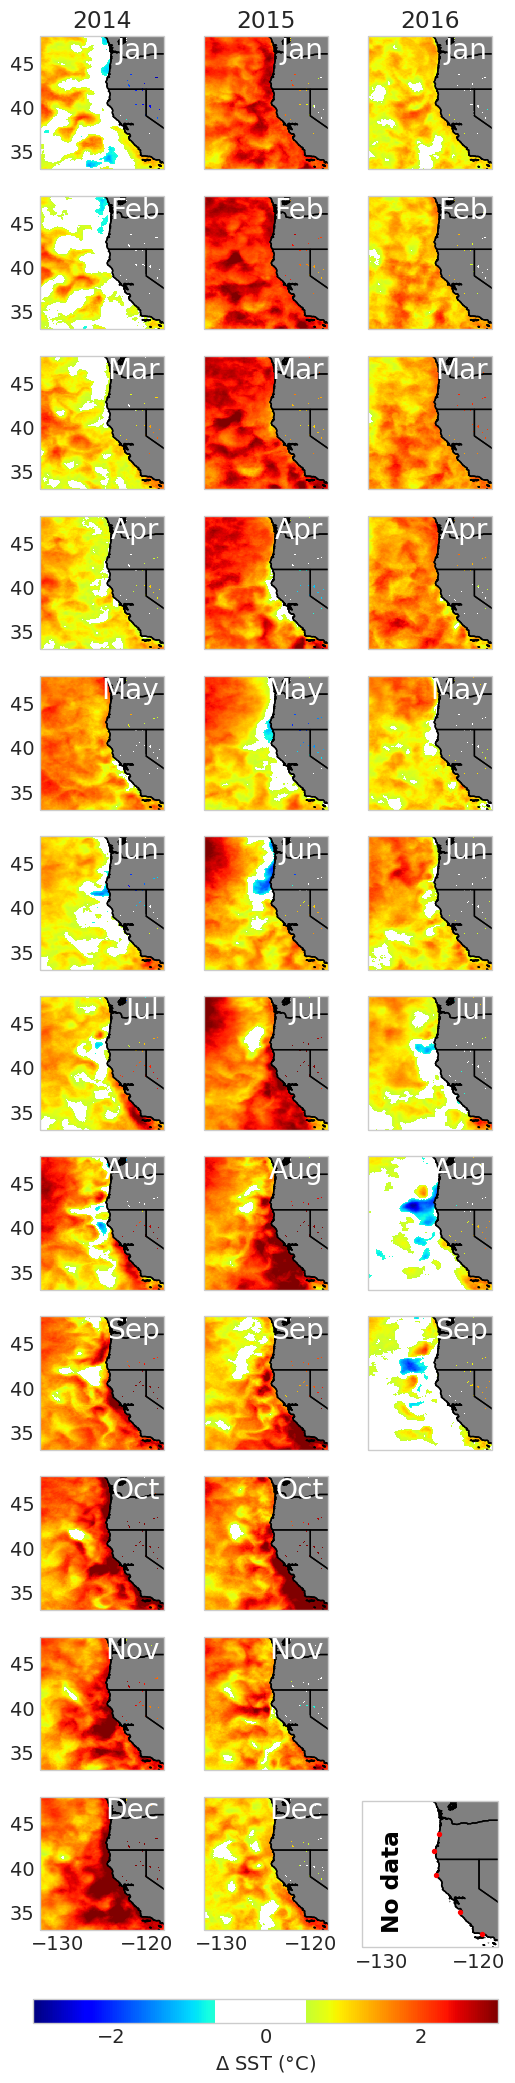

In [15]:
fig = plt.figure(figsize=(6, 30))

axes = []
for year in np.arange(2014, 2017):
    for month in np.arange(1, 13):
        if year == 2016 and month > 9:  # don't need to plot beyond September 2016
            break
        ax = plt.subplot(12, 3, (year - 2014) + (month-1) * 3 + 1, projection=crs)
        make_fig(ax, month_names[month-1], anomalies[(month, year)], xticks=(month==12), yticks=(year==2014))
        if month == 1:
            ax.set_title(year)
        else:
            ax.set_title(None)
        axes.append(ax)

nodata_ax = plt.subplot(12, 3, 30, projection=crs)
plot_nodata(nodata_ax)

norm = colors.Normalize(vmin=-3, vmax=3)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap),
             ax=axes,
             location="bottom",
             orientation='horizontal',
             label=r'$\Delta$ SST ($\degree$C)',
             pad=0.03,
             ticks=[-2, 0, 2]
)

plt.savefig("outputs/Q04.png", bbox_inches="tight")